In [1]:
#import data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold,train_test_split
from sklearn.feature_selection import RFECV
%config IPCompleter.greedy=True

In [2]:
#os.path.isfile('/Users⁩/shrimp⁩/⁨Documents⁩/⁨GitHub/Jupyter/train.csv')
os.chdir('/Users/shrimp/Documents/GitHub/Jupyter/')

In [3]:
train = pd.read_csv('train.csv',index_col=0)

In [4]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train.shape

(1460, 80)

In [6]:
test=pd.read_csv('test.csv',index_col=0)

In [7]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [8]:
test.shape[0]

1459

In [9]:
submission=pd.read_csv('sample_submission.csv',index_col=0)
submission.head()

,SalePrice
Id,
1461,169277.052498
1462,187758.393989
1463,183583.683570
1464,179317.477511
1465,150730.079977


In [10]:
train['SalePrice'].describe()


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

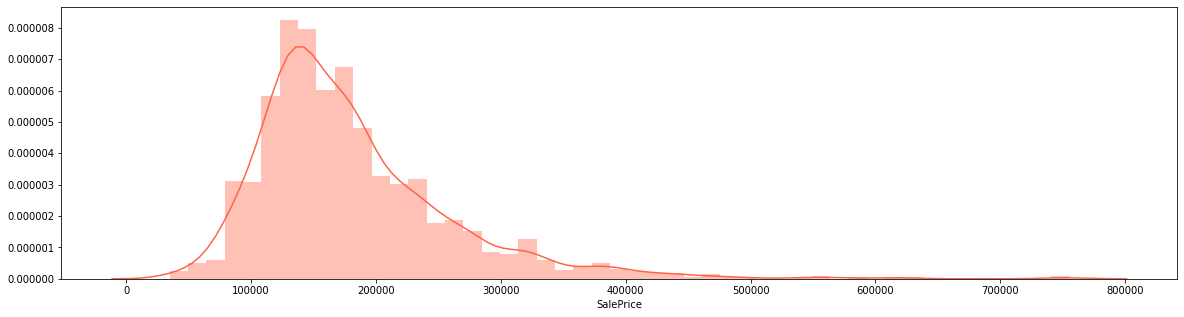

In [11]:
plt.figure(figsize=(20,5))
sns.distplot(train.SalePrice,color='tomato')

In [12]:
#in case of positive skewness, use log transformations. 
#train['SalePriceInLog'] = np.log(train.SalePrice+1)
#sns.distplot(train.SalePriceInLog,color='tomato')
#train.shape[1]

### Relationship with numerical variables

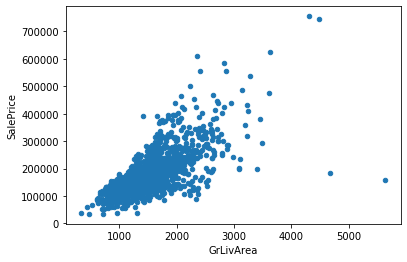

In [13]:
#check relation between SalePrice and GrLivArea
train.plot.scatter('GrLivArea','SalePrice')

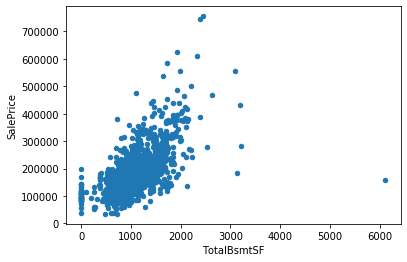

In [14]:
#check relation between TotalBsmtSF and SalePrice
train.plot.scatter('TotalBsmtSF','SalePrice')

### Relationship with categorical variables

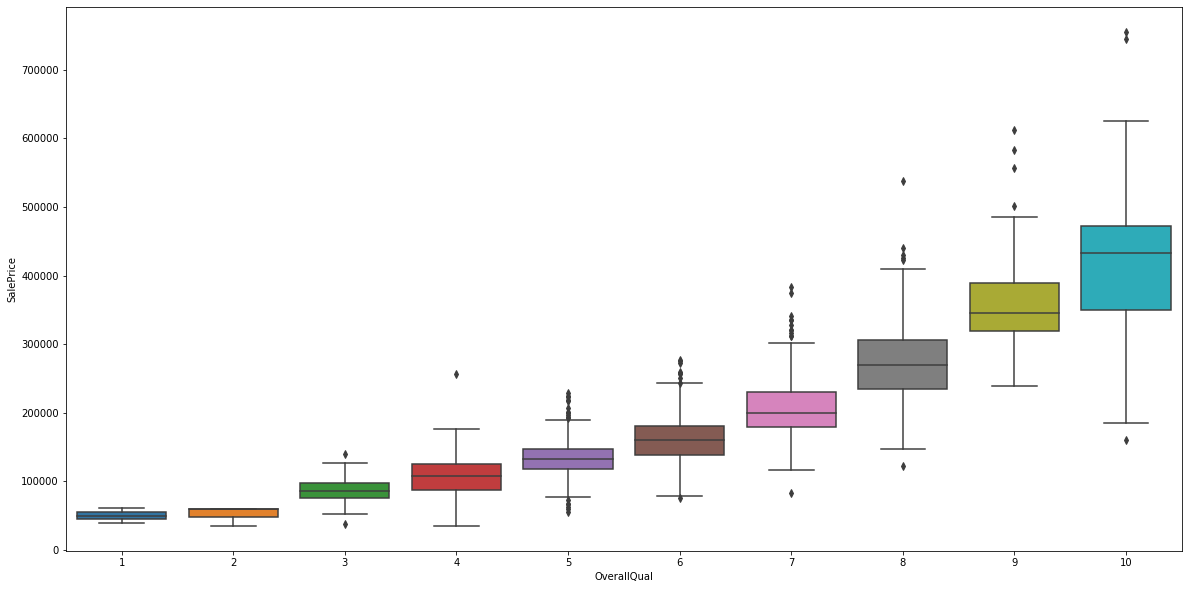

In [15]:
#box plot overallqual/saleprice
plt.figure(figsize=(20,10))
sns.boxplot(x=train['OverallQual'],y=train['SalePrice'])

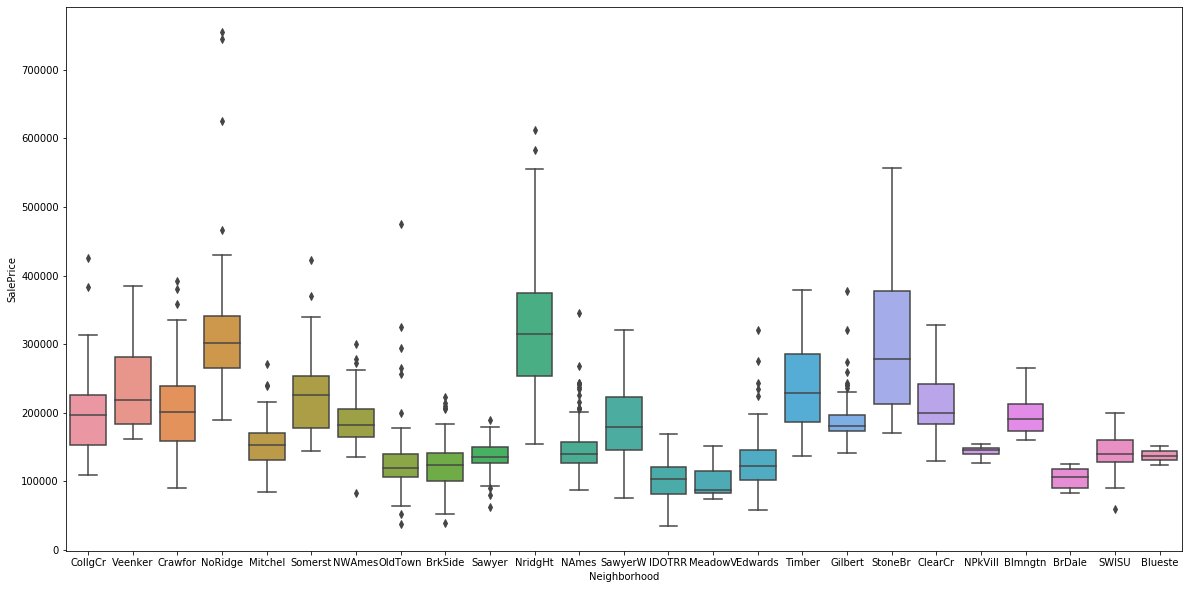

In [16]:
#box plot Neighborhood/SalePrice. Intuitively Neighborhood could be very important feature. 
plt.figure(figsize=(20,10))
sns.boxplot(x=train['Neighborhood'],y=train['SalePrice'])

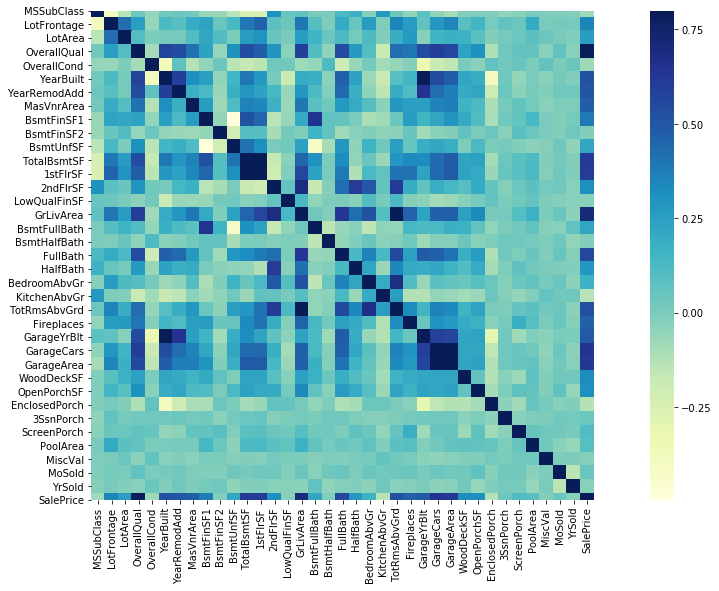

In [17]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corrmat, vmax=.8, square=True,cmap="YlGnBu");

### Take care of missing values
1.first need to check if in train set, target SalePrice has nulls
2.Comnbie train and test sets, remove those with more than 10% of missing data.
3.For categorical columns, drop all features that more than 90% of rows belongs to One category.
4.For numerical columns, check if there're numbers but acutally are categoricals and drop if >90%
5.Imputing missing values

additional thoughts on 3.
Many categorical candidates have less frequent levels.
This is a problem as it might be difficult to generalize well during training if there is only a handful of samples with a specific level.
We could either fuse levels or we add information to the frequency of levels as well as level target information like mean, median, std.

In [18]:
#1.first need to check if in train set, target SalePrice has nulls
train[train['SalePrice']<=0]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,


In [19]:
#combine train and test sets: features only!
combined = train.drop('SalePrice',axis=1).append(test)
combined.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [20]:
missing_total = combined.isnull().sum().sort_values(ascending=False)
missing_percent = (combined.isnull().sum()/combined.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([missing_total,missing_percent],axis=1,keys=['missing_total','missing_percent'])
missing_data.head(10)

,missing_total,missing_percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageCond,159,0.054471
GarageQual,159,0.054471
GarageYrBlt,159,0.054471
GarageFinish,159,0.054471


In [21]:
#2.remove those with more than 10% of missing data.
dropped_col1= missing_data[missing_data['missing_percent']>0.1].index
combined = combined.drop(dropped_col1,1)
dropped_col1


Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
       'LotFrontage'],
      dtype='object')

In [22]:
#3.For categorical columns, drop all features that more than 90% of rows belongs to One category.
cat_candidates = combined.dtypes[combined.dtypes=="object"].index.values
cat_candidates

array(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'], dtype=object)

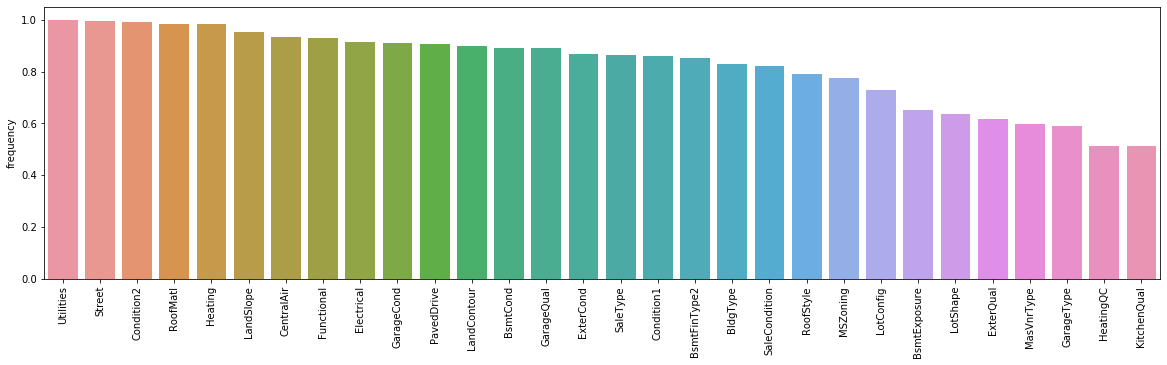

In [23]:
frequencies = []
for col in cat_candidates:
    overall_freq = combined.loc[:, col].value_counts().max() / combined.shape[0]
    frequencies.append([col, overall_freq])

frequencies = np.array(frequencies)
freq_df = pd.DataFrame(index=frequencies[:,0], data=frequencies[:,1], columns=["frequency"])
sorted_freq = freq_df.frequency.sort_values(ascending=False)

plt.figure(figsize=(20,5))
sns.barplot(x=sorted_freq.index[0:30], y=sorted_freq[0:30].astype(np.float))
plt.xticks(rotation=90);

In [24]:
#drop those columns where >=0.9
freq_df.frequency = freq_df.frequency.astype(np.float)
cats_to_drop = freq_df[freq_df.frequency >= 0.9].index.values
len(cats_to_drop)

11

In [25]:
cats_to_drop

array(['Street', 'Utilities', 'LandSlope', 'Condition2', 'RoofMatl',
       'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageCond',
       'PavedDrive'], dtype=object)

In [26]:
combined=combined.drop(cats_to_drop,1)


In [27]:
combined.shape

(2919, 62)

In [28]:
#4.For numerical columns, check if there're apprear to be numbers but acutally are categoricals and drop if >90%
num_columns = combined.dtypes[combined.dtypes!='object'].index
num_columns
combined.loc[:,num_columns].head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1,60,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,...,548.0,0,61,0,0,0,0,0,2,2008
2,20,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,...,460.0,298,0,0,0,0,0,0,5,2007
3,60,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,...,608.0,0,42,0,0,0,0,0,9,2008
4,70,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,...,642.0,0,35,272,0,0,0,0,2,2006
5,60,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,...,836.0,192,84,0,0,0,0,0,12,2008


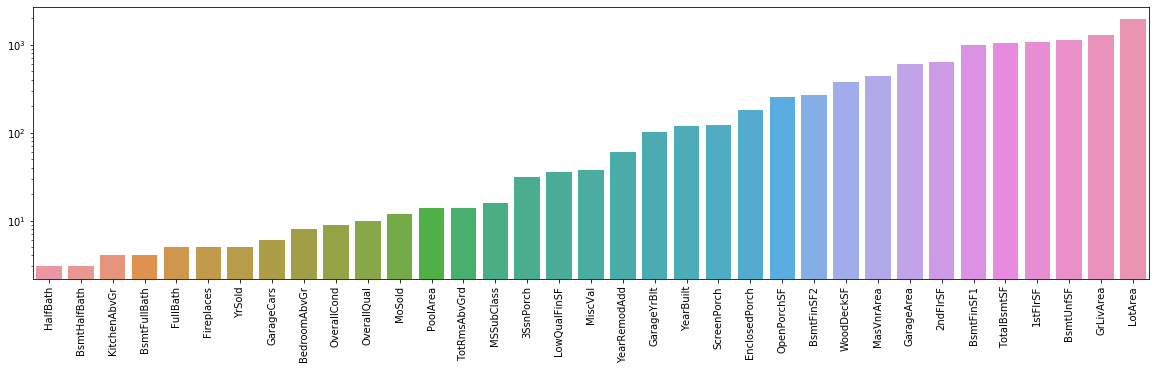

In [29]:
#get those appear to be numerical but actually categorical
unique_counts = combined.loc[:, num_columns].nunique().sort_values()

plt.figure(figsize=(20,5))
sns.barplot(unique_counts.index, unique_counts.values)
plt.xticks(rotation=90);
plt.yscale("log")

In [30]:
#get frequnency for those appear to be numerical but actually categorical
next_cat_candidates = [
    "OverallQual", "OverallCond", "MSSubClass", 'BsmtFullBath',
    'BsmtHalfBath','FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
    'TotRmsAbvGrd', 'Fireplaces', 'GarageCars','YrSold','MoSold','PoolArea'
]

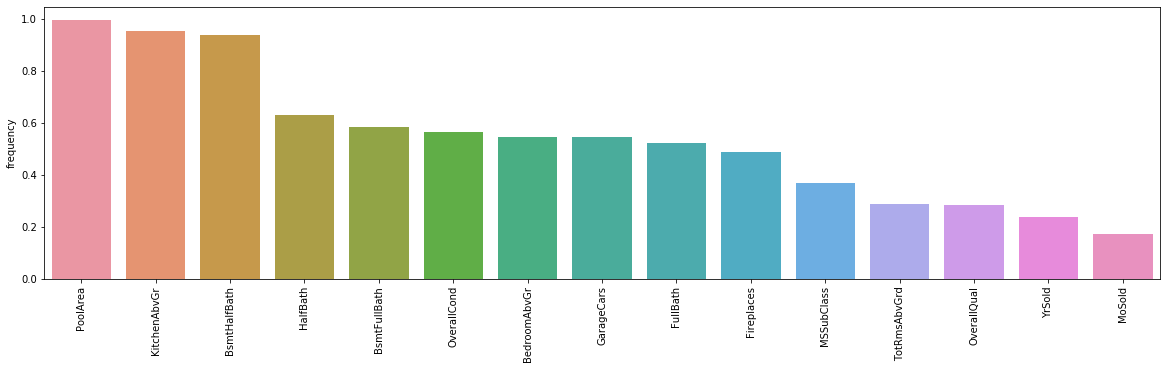

In [31]:
frequencies = []
for col in next_cat_candidates:
    overall_freq = combined.loc[:, col].value_counts().max() / combined.shape[0]
    frequencies.append([col, overall_freq])

frequencies = np.array(frequencies)
freq_df = pd.DataFrame(index=frequencies[:,0], data=frequencies[:,1], columns=["frequency"])
sorted_freq = freq_df.frequency.sort_values(ascending=False)

plt.figure(figsize=(20,5))
sns.barplot(x=sorted_freq.index[0:30], y=sorted_freq[0:30].astype(np.float))
plt.xticks(rotation=90);

In [32]:
#remove those >0.9
cats_to_drop = ['KitchenAbvGr', 'BsmtHalfBath','PoolArea']
combined = combined.drop(cats_to_drop, axis=1)

In [33]:
combined.shape

(2919, 59)

In [34]:
for col in cats_to_drop:
    next_cat_candidates.remove(col)

In [35]:
#change data types for those 'numerical' to categoricals
for col in next_cat_candidates:
    combined[col] = combined[col].astype("object")

In [36]:
num_columns=combined.dtypes[combined.dtypes!='object'].index

In [37]:
#5.Imputing missing values
def impute_na_trees(df, col):
    if df[col].dtype == "object":
        df[col] = df[col].fillna("Unknown")
        df[col] = df[col].astype("object")
    else:
        df[col] = df[col].fillna(-99999)
    return df

In [38]:
for col in combined.columns:
    combined = impute_na_trees(combined, col)

In [39]:
num_columns

Index(['LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal'],
      dtype='object')

In [40]:
cat_candidates = combined.dtypes[combined.dtypes=='object'].index.values

In [41]:
combined.isnull().sum().sum()

0

### features Encoding
1.Encoding categorical features
uisng Target encoidng: how targets are distributed in each level, and order thoes levels based on the mean/median of the target in each level.


In [42]:
#1.categorical features need Encoding 
cat_candidates

array(['MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'LotConfig',
       'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'RoofStyle', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'BsmtFullBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageType', 'GarageFinish',
       'GarageCars', 'GarageQual', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition'], dtype=object)

In [43]:
len(cat_candidates)

39

In [44]:
df_train = combined.iloc[0:train.shape[0]].copy()
df_train.loc[:, "target"] = np.log(train.SalePrice+1)
df_test = combined.iloc[train.shape[0]::].copy()

In [45]:
df_train.shape

(1460, 60)

In [46]:
df_test.shape

(1459, 59)

In [47]:
#how targets are distributed in each level, and order thoes levels based on the mean/median 
#of the target in each level.
enc_map = {}

for col in cat_candidates:
    order = df_train.groupby(col).target.median().sort_values().index.values
    enc_map[col] = {}
    for n in range(len(order)):
        enc_map[col][order[n]] = n

In [48]:
for col in cat_candidates:
    combined[col + "_order"] = combined[col].map(enc_map[col])

In [49]:
combined.loc[:, cat_candidates].isnull().sum().sum()

0

### Removing Outliers

In [50]:
#check if have 
i=0
for col in num_columns:
    if 'Area' in col:
        i+= df_train[df_train['LotArea']<0].shape[0]
        
i

0

### Feature selection
option1(more time consuming).remove features recusively
option2(less time consuming).random forest feature importance

In [51]:
#after feature encoding, construct df_test,df_test
df_train = combined.iloc[0:train.shape[0]].copy()
df_train.loc[:, "target"] = np.log(train.SalePrice+1)
df_test = combined.iloc[train.shape[0]::].copy()

combined = df_train.drop("target", axis=1).append(df_test,sort=True)

In [52]:
#make sure fill nulls for those categorical values in test set but not seen in train set
combined = combined.fillna(-1)
combined.isnull().sum().sum()

0

In [53]:
df_test.head()

,MSSubClass,MSZoning,LotArea,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,...,TotRmsAbvGrd_order,Fireplaces_order,GarageType_order,GarageFinish_order,GarageCars_order,GarageQual_order,MoSold_order,YrSold_order,SaleType_order,SaleCondition_order
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,11622,Reg,Lvl,Inside,NAmes,Feedr,1Fam,1Story,...,3.0,0.0,5,1,1.0,4,4,0,5.0,4
1462,20,RL,14267,IR1,Lvl,Corner,NAmes,Norm,1Fam,1Story,...,4.0,0.0,5,1,1.0,4,4,0,5.0,4
1463,60,RL,13830,IR1,Lvl,Inside,Gilbert,Norm,1Fam,2Story,...,4.0,1.0,5,3,2.0,4,6,0,5.0,4
1464,60,RL,9978,IR1,Lvl,Inside,Gilbert,Norm,1Fam,2Story,...,5.0,1.0,5,3,2.0,4,4,0,5.0,4
1465,120,RL,5005,IR1,HLS,Inside,StoneBr,Norm,TwnhsE,1Story,...,3.0,0.0,5,2,2.0,4,1,0,5.0,4


In [54]:
combined.loc[:, cat_candidates].isnull().sum().sum()

0

In [55]:
df_train.shape

(1460, 99)

In [56]:
len(cat_candidates)

39

In [57]:
#Random Forest: check feature importance 
use_cols = [col for col in df_train.columns if col not in cat_candidates and col != "target" and col != 'SalePrice']
len(use_cols)

59

In [58]:
forest = RandomForestRegressor(n_estimators=51, max_depth=4, random_state=8)
kfold = KFold(6, random_state=88)
forest_selector = RFECV(estimator=forest, step=1, scoring="neg_mean_squared_error", n_jobs=-1)

In [59]:
Y_train = df_train.target.values
X_train = df_train[use_cols].values


In [60]:
#define df_test
df_test = combined.iloc[train.shape[0]::].copy()
X_test = df_test[use_cols].values

In [61]:
X_train

array([[8.450e+03, 2.003e+03, 2.003e+03, ..., 3.000e+00, 5.000e+00,
        4.000e+00],
       [9.600e+03, 1.976e+03, 1.976e+03, ..., 4.000e+00, 5.000e+00,
        4.000e+00],
       [1.125e+04, 2.001e+03, 2.002e+03, ..., 3.000e+00, 5.000e+00,
        4.000e+00],
       ...,
       [9.042e+03, 1.941e+03, 2.006e+03, ..., 0.000e+00, 5.000e+00,
        4.000e+00],
       [9.717e+03, 1.950e+03, 1.996e+03, ..., 0.000e+00, 5.000e+00,
        4.000e+00],
       [9.937e+03, 1.965e+03, 1.965e+03, ..., 3.000e+00, 5.000e+00,
        4.000e+00]])

In [62]:
forest_selector.fit(X_train, Y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


RFECV(cv='warn',
      estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                      max_depth=4, max_features='auto',
                                      max_leaf_nodes=None,
                                      min_impurity_decrease=0.0,
                                      min_impurity_split=None,
                                      min_samples_leaf=1, min_samples_split=2,
                                      min_weight_fraction_leaf=0.0,
                                      n_estimators=51, n_jobs=None,
                                      oob_score=False, random_state=8,
                                      verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=-1, scoring='neg_mean_squared_error',
      step=1, verbose=0)

In [63]:
forest_feature_ranking = pd.DataFrame(index=df_train[use_cols].columns.values, 
                                      data=forest_selector.ranking_, 
                                      columns=["ranking"])
forest_feature_ranking = forest_feature_ranking.ranking.sort_values()

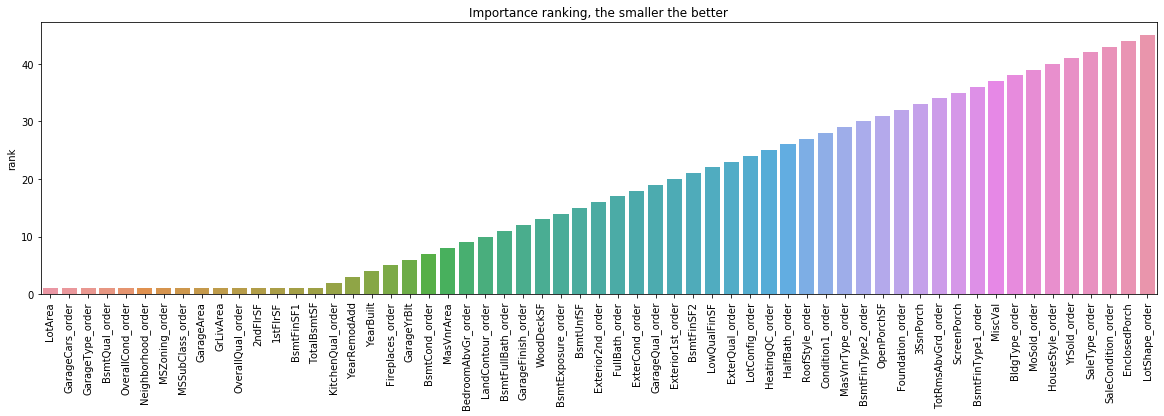

In [64]:
plt.figure(figsize=(20,5))
sns.barplot(forest_feature_ranking.index, forest_feature_ranking.values)
plt.xticks(rotation=90);
plt.ylabel("rank")
plt.title("Importance ranking, the smaller the better");

In [65]:
#select features with ranking<10 
selection = forest_feature_ranking[forest_feature_ranking<10].index.values
selection

array(['LotArea', 'GarageCars_order', 'GarageType_order',
       'BsmtQual_order', 'OverallCond_order', 'Neighborhood_order',
       'MSZoning_order', 'MSSubClass_order', 'GarageArea', 'GrLivArea',
       'OverallQual_order', '2ndFlrSF', '1stFlrSF', 'BsmtFinSF1',
       'TotalBsmtSF', 'KitchenQual_order', 'YearRemodAdd', 'YearBuilt',
       'Fireplaces_order', 'GarageYrBlt', 'BsmtCond_order', 'MasVnrArea',
       'BedroomAbvGr_order'], dtype=object)

In [66]:
df_train[selection].shape

(1460, 23)

In [67]:
df_train.target

Id
1       12.247699
2       12.109016
3       12.317171
4       11.849405
5       12.429220
          ...    
1456    12.072547
1457    12.254868
1458    12.493133
1459    11.864469
1460    11.901590
Name: target, Length: 1460, dtype: float64

In [68]:
#notice 
x1_train,x1_test,y1_train,y1_test = train_test_split(df_train[selection],df_train.target,test_size=0.2,random_state=6)

In [69]:
clf= RandomForestRegressor(n_estimators=501,criterion='mse',max_depth=5,oob_score=True)

In [70]:
clf.fit(x1_train,y1_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=501,
                      n_jobs=None, oob_score=True, random_state=None, verbose=0,
                      warm_start=False)

In [71]:
clf.feature_importances_

array([6.01450062e-03, 2.87881838e-02, 9.51835997e-03, 4.72626570e-03,
       7.58325457e-03, 6.82653558e-02, 5.38188147e-03, 4.33800541e-03,
       1.18450031e-02, 1.18656122e-01, 6.26824655e-01, 3.17673319e-03,
       2.33010654e-02, 1.63290202e-02, 3.72364990e-02, 1.79126770e-03,
       6.06943261e-03, 7.61591975e-03, 2.82697621e-03, 6.81044135e-03,
       1.53287122e-03, 8.91393469e-04, 4.76792459e-04])

In [72]:
y1_pred=clf.predict(x1_test)

In [73]:
#calculate MSE
np.sum(np.power((y1_pred-y1_test),2)) / len(y1_pred)

0.026893769276170643

In [74]:
df_test[selection].isnull().sum().sum()

0

In [75]:
Y_pred = clf.predict(df_test[selection])

In [76]:
Y_pred[0:5]

array([11.76169987, 11.91086656, 12.07374657, 12.09722661, 12.26687513])

In [77]:
Y_pred=np.exp(Y_pred)

In [78]:
Y_pred

array([128245.26818193, 148875.63327509, 175211.05832723, ...,
       152071.54906342, 123288.10325513, 232893.65956515])

In [79]:
Prediction= pd.DataFrame(Y_pred,  columns=['SalePrice'])

In [80]:
result = pd.concat([ pd.DataFrame(df_test.index.values, columns=['Id']) ,Prediction],axis=1)

In [81]:
result.head()

,Id,SalePrice
0,1461,128245.268182
1,1462,148875.633275
2,1463,175211.058327
3,1464,179373.698088
4,1465,212537.799906


In [82]:
result.to_csv('submission_Benchmark.csv', index=False)